In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Mar  8 22:25:46 2020

@author: Jerry
"""
import time
start_time = time.time()
import numpy as np
import pandas as pd
import os
import re
import nltk
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


In [2]:
vectorizer = CountVectorizer() 
tfidf_transformer = TfidfTransformer()
tfidf_test_transformer = TfidfTransformer()
lemmatizer = WordNetLemmatizer()
x_tokenizer = nltk.tokenize.WhitespaceTokenizer()

In [11]:
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~='''
    
def lemmatize_review(review):
    temp = ' '.join(lemmatizer.lemmatize(x) for x in x_tokenizer.tokenize(review))
    return temp

IMDB_train = []

#Reads + cleans training data 
for x in range(0,2):
    if x == 0: 
        review = 'neg'
    else: 
        review = 'pos'
        
    entries = os.listdir('aclImdb/train/' + review)
    print(len(entries[:6250]))
    for entry in entries[:6250]:
        f = open('aclImdb/train/' + review + '/' + entry, encoding="utf8")
        file_content = f.read().lower().strip()
        file_content = file_content.replace('<br />','')
        file_content = file_content.replace('<br>','')
        #removing digits and punctuations
        file_content = re.sub(r'\d+', '', file_content)
        file_content = ''.join([i for i in file_content if i not in punctuations])

        lemmatized_file_content = lemmatize_review(file_content)
        
        #extract the rating, ID
        rating = int(entry[entry.find('_')+1:entry.find('.')])
        ID = entry[:entry.find('_')]
        result = [ID, lemmatized_file_content, rating, x]
        IMDB_train.append(result)

#Reads + cleans Testing data
IMDB_test = []
for x in range(0,2):
    if x == 0: 
        review = 'neg'
    else: 
        review = 'pos'
        
    entries = os.listdir('aclImdb/test/' + review)
    print(len(entries[:6250]))
    for entry in entries[:6250]:
        f = open('aclImdb/test/' + review + '/' + entry, encoding="utf8")
        file_content = f.read().lower().strip()
        file_content = file_content.replace('<br />','')
        file_content = file_content.replace('<br>','')
        #removing digits and punctuations
        file_content = re.sub(r'\d+', '', file_content)
        file_content = ''.join([i for i in file_content if i not in punctuations])

        lemmatized_file_content = lemmatize_review(file_content)
        
        #extract the rating, ID
        rating = int(entry[entry.find('_')+1:entry.find('.')])
        ID = entry[:entry.find('_')]
        result = [ID, lemmatized_file_content, rating, x]
        IMDB_test.append(result)
 

6250
6250
6250
6250


In [14]:
#convert training data to dataframe -> count vectorizer -> TDIDF
IMDB_train = np.array(IMDB_train)
df_train = pd.DataFrame(IMDB_train, columns = ['ID', 'Reviews', 'Rating', 'Score'])
df_train = shuffle(df_train)
Y_train = df_train['Score']
df_train_x = df_train.drop('Score', axis=1)

foovec = CountVectorizer(min_df =1, tokenizer = nltk.word_tokenize, stop_words = 'english')
IMDB_train_count = foovec.fit_transform(df_train_x.Reviews)
X_train = tfidf_transformer.fit_transform(IMDB_train_count)

#convert testing data to dataframe -> count vectorizer -> TDIDF
IMDB_test = np.array(IMDB_test)
df_test = pd.DataFrame(IMDB_test, columns = ['ID', 'Reviews', 'Rating', 'Score'])
df_test = shuffle(df_test)
Y_test = df_test['Score']
df_test_x = df_test.drop('Score', axis=1)


IMDB_test_count = foovec.transform(df_test_x.Reviews)
X_test = tfidf_transformer.transform(IMDB_test_count)

## Train each model and print the accuracy using the default score

In [15]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.05, solver = 'lbfgs')
lr.fit(X_train,Y_train)
Y_predict = lr.predict(X_test)
print ("Accuracy_LR:", accuracy_score(Y_test,Y_predict))

#Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=12)
dt.fit(X_train,Y_train)
Y_predict = dt.predict(X_test)
print ("Accuracy_DT:", accuracy_score(Y_test,Y_predict))

#Predict test docs using SVM---------------------------------------------------
from sklearn.svm import LinearSVC
svm = LinearSVC(random_state=12, tol=1e-5)
svm.fit(X_train,Y_train)
Y_predict = svm.predict(X_test)
print ("Accuracy_SVM:", accuracy_score(Y_test,Y_predict))

#Predict test docs using AdaBoost---------------------------------------------
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier(n_estimators=100, random_state=12)
ab.fit(X_train,Y_train)
Y_predict = ab.predict(X_test)
print ("Accuracy_AB:", accuracy_score(Y_test,Y_predict))


#Predict test docs using Random Forest Classifier------------------------------
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=10, random_state=12)
rf.fit(X_train,Y_train)
Y_predict = rf.predict(X_test)
print ("Accuracy_RF:", accuracy_score(Y_test,Y_predict))

print ("My program took", time.time() - start_time, "to run")


Accuracy_LR: 0.82176
Accuracy_DT: 0.69648
Accuracy_SVM: 0.85672
Accuracy_AB: 0.81512
Accuracy_RF: 0.81472
My program took 2197.69553565979 to run


## Train Multinomial Naive Bayes and print accuracy

In [102]:
#Predict test docs using MultinomialNB------------------------------
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, Y_train)
Y_predict = nb.predict(X_test)
print ("Accuracy_NB:", accuracy_score(Y_test,Y_predict))

Accuracy_NB: 0.82512


## Compare the cross_val_score implementation to KFold and Stratified KFold
Only for informational purposes

In [21]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
# Just uses the data from the training set, implement k-fold validation
scores = cross_val_score(lr, X_train, Y_train, cv=5)
scores1 = cross_val_score(lr, X_train, Y_train, cv=KFold(n_splits=5))
scores2 = cross_val_score(lr, X_train, Y_train, cv=StratifiedKFold(n_splits=5))
print(scores)
print(scores1)
print(scores2)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))

[0.8048 0.824  0.8076 0.814  0.8188]
[0.8048 0.8188 0.81   0.816  0.8192]
[0.8048 0.824  0.8076 0.814  0.8188]
Accuracy: 0.81 (+/- 0.01)
Accuracy: 0.81 (+/- 0.01)
Accuracy: 0.81 (+/- 0.01)


# GridSearchCV
## Print the possible hyperparameters to be tweaked for each model

In [109]:
print("\nlr\n", lr.get_params())
print("\ndt\n", dt.get_params())
print("\nsvm\n", svm.get_params())
print("\nab\n", ab.get_params())
print("\nrf\n", rf.get_params())
print("\nnb\n", nb.get_params())


lr
 {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

dt
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}

svm
 {'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}

ab
 {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}

rf
 {'bootstrap': True, 'ccp_

## Logistic Regression

In [85]:
from sklearn.model_selection import GridSearchCV
param_grid = [
   {
    'penalty' : ['l2'],
    'C' : np.logspace(-2, 1, 10),
    'solver' : ['lbfgs'],
    'tol': [0.0001,0.00001,0.001,0.01,0.1,1],
    'random_state': [12]
   },
]

lr = LogisticRegression()
gsc = GridSearchCV(lr, param_grid, cv=5)
gsc.fit(X_train,Y_train)
print(gsc.best_params_)
gsc_Y_predict = gsc.predict(X_test)

print ("Accuracy_LR:", accuracy_score(Y_test, gsc_Y_predict))

{'C': 10.0, 'penalty': 'l2', 'random_state': 12, 'solver': 'lbfgs', 'tol': 1}
Accuracy_LR: 0.8604


## Decision Tree

In [86]:
param_grid = [
   {
    'ccp_alpha' : np.append(np.logspace(-3, .01, 10), 0),
    'splitter' : ['best'],
    'random_state': [12],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'max_features': [None],#[2,3,4],
   },
]

dt = DecisionTreeClassifier()
gscdt = GridSearchCV(dt, param_grid, cv=5)
gscdt.fit(X_train, Y_train)
print(gscdt.best_params_)
gscdt_Y_predict = gscdt.predict(X_test)

print ("Accuracy_DT:", accuracy_score(Y_test, gscdt_Y_predict))

{'ccp_alpha': 0.001, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 12, 'splitter': 'best'}
Accuracy_DT: 0.74672


## Linear Support Vector

In [87]:

param_grid = [
   {
    'penalty' : ['l2'],
    'C' : np.logspace(-2, 1, 10),
    'tol': [0.000001,0.00001,0.0001,0.001],
    'random_state': [12]
   },
]

svm = LinearSVC()
gsc = GridSearchCV(svm, param_grid, cv=5)
gsc.fit(X_train,Y_train)
print(gsc.best_params_)
gsc_Y_predict = gsc.predict(X_test)

print ("Accuracy_SVM:", accuracy_score(Y_test, gsc_Y_predict))

{'C': 0.21544346900318834, 'penalty': 'l2', 'random_state': 12, 'tol': 1e-06}
Accuracy_SVM: 0.86584


## AdaBoost

In [91]:

param_grid = [
   {
    'n_estimators':[50,100,200],
    'learning_rate': [0.9, 1.0, 1.1],
    'random_state': [12]
   },
]

ab = AdaBoostClassifier()
gsc = GridSearchCV(ab, param_grid, cv=5)
gsc.fit(X_train,Y_train)
print(gsc.best_params_)
gsc_Y_predict = gsc.predict(X_test)

print ("Accuracy_AB:", accuracy_score(Y_test, gsc_Y_predict))

{'learning_rate': 0.9, 'n_estimators': 200, 'random_state': 12}
Accuracy_AB: 0.8292


## Random Forest

In [92]:

param_grid = [
   {
    'ccp_alpha': [0.0],
    'max_depth': [10, None],
    'random_state': [12]
   },
]

rf = RandomForestClassifier()
gsc = GridSearchCV(rf, param_grid, cv=5)
gsc.fit(X_train,Y_train)
print(gsc.best_params_)
gsc_Y_predict = gsc.predict(X_test)

print ("Accuracy_RF:", accuracy_score(Y_test, gsc_Y_predict))

{'ccp_alpha': 0.0, 'max_depth': None, 'random_state': 12}
Accuracy_RF: 0.83328


## Multinomial Naive Bayes

In [108]:

param_grid = [
   {
    'alpha': np.logspace(-3, 1, 40),
   },
]

nb = MultinomialNB()
gsc = GridSearchCV(nb, param_grid, cv=5)
gsc.fit(X_train, Y_train)
print(gsc.best_params_)
gsc_Y_predict = gsc.predict(X_test)

print ("Accuracy_NB:", accuracy_score(Y_test, gsc_Y_predict))

{'alpha': 1.9144819761699576}
Accuracy_NB: 0.83088


# Word Cloud

         ID                                            Reviews Rating Score
5128   7499  john leguizemo a wonderful comic actor is a ne...      3     0
11968  6647  gandhi my father is like viewing a book chapte...      8     1
309    4968  i wa expecting the movie based on grendel the ...      1     0
10284  7537  contrary to what those who hate christianity t...     10     1
7242   1415  i saw the german version of the movie in germa...     10     1
        ID                                            Reviews Rating Score
5128  7499  john leguizemo a wonderful comic actor is a ne...      3     0
309   4968  i wa expecting the movie based on grendel the ...      1     0
2387  6074  what a bad movie im really surprised that deni...      3     0
4458  8017  i havent actually finished the film you may sa...      3     0
807   6711  wa the year this wa long before phillip seymou...      2     0


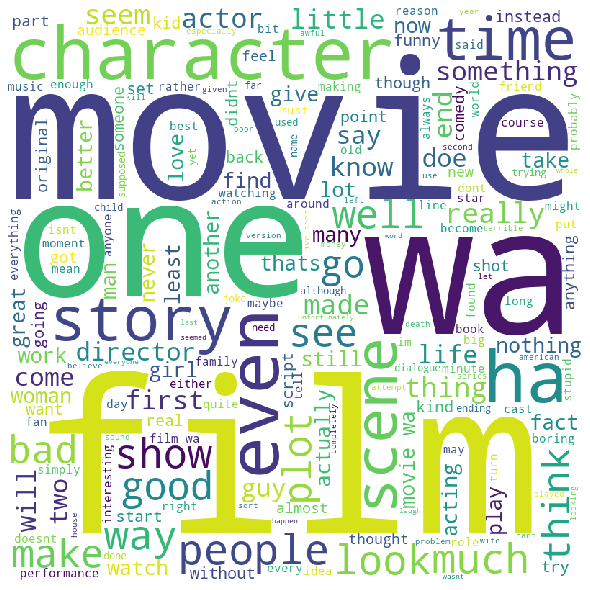

In [119]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stp = set(STOPWORDS)
print(df_train.head())
# Choose all the reviews that have negative sentiment words, 
# for positive sentiment words word cloud change score to '1'
trn_words = df_train[df_train['Score'] == '0']

print(trn_words.head())

trn_words_array = ' '.join(trn_words['Reviews'].tolist())

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stp, 
                min_font_size = 10).generate(trn_words_array) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()